In [33]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle

from scipy import stats
from scipy.special import boxcox1p

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from itertools import product

import gc

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [34]:
from numba import jit

In [35]:
@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)



In [36]:
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc

In [37]:
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    is_higher_better = True
    return 'MCC', best_mcc, is_higher_better

In [38]:
meta_train = pd.read_csv('../input/metadata_train.csv')
meta_test = pd.read_csv('../input/metadata_test.csv')

In [39]:
numpeaks = np.load('../features/numpeaks.npy')
numpospeaks = np.load('../features/numpospeaks.npy')
numnegpeaks = np.load('../features/numnegpeaks.npy')

maxpeakwidth = np.load('../features/maxpeakwidth.npy')
minpeakwidth = np.load('../features/minpeakwidth.npy')
meanpeakwidth = np.load('../features/meanpeakwidth.npy')
maxamp = np.load('../features/maxamp.npy')
minamp = np.load('../features/minamp.npy')
meanamp = np.load('../features/meanamp.npy')

stdampall = np.load('../features/stdampall.npy')
stdposall = np.load('../features/stdposall.npy')
stdwidthall = np.load('../features/stdwidthall.npy')

stdampq2 = np.load('../features/stdampq2.npy')
stdposq2 = np.load('../features/stdposq2.npy')
stdwidthq2 = np.load('../features/stdwidthq2.npy')
stdampq3 = np.load('../features/stdampq3.npy')
stdposq3 = np.load('../features/stdposq3.npy')
stdwidthq3 = np.load('../features/stdwidthq3.npy')
stdampq4 = np.load('../features/stdampq4.npy')
stdposq4 = np.load('../features/stdposq4.npy')
stdwidthq4 = np.load('../features/stdwidthq4.npy')


In [40]:
stdampall_ad = np.load('../features/stdampall_ad.npy')
stdampq2_ad = np.load('../features/stdampq2_ad.npy')
stdampq3_ad = np.load('../features/stdampq3_ad.npy')
stdampq4_ad = np.load('../features/stdampq4_ad.npy')

meanampall_ad = np.load('../features/meanampall_ad.npy')
meanampq2_ad = np.load('../features/meanampq2_ad.npy')
meanampq3_ad = np.load('../features/meanampq3_ad.npy')
meanampq4_ad = np.load('../features/meanampq4_ad.npy')

meanamppos = np.load('../features/meanamppos.npy')
meanampneg = np.load('../features/meanampneg.npy')


In [41]:
numpeaks_id = np.load('../features/numpeaks_id.npy')
numpospeaks_id = np.load('../features/numpospeaks_id.npy')
numnegpeaks_id = np.load('../features/numnegpeaks_id .npy')

maxamp_id = np.load('../features/maxamp_id.npy')
minamp_id = np.load('../features/minamp_id.npy')
meanamp_id = np.load('../features/meanamp_id.npy')

meanamppos_id = np.load('../features/meanamppos_id.npy')
meanampneg_id = np.load('../features/meanampneg_id.npy')


In [42]:
train_features = pd.DataFrame({'NumPeaks':numpeaks, 'NumPosPeaks':numpospeaks, 'NumNegPeaks':numnegpeaks, 'MaxWidth':maxpeakwidth,
                         'MinWidth':minpeakwidth, 'MeanWidth':meanpeakwidth, 'MaxAmp':maxamp, 'MinAmp':minamp, 'MeanAmp':meanamp,
                        'StdAmpAll':stdampall, 'StdPosAll':stdposall, 'StdWidthAll':stdwidthall, 'StdAmpQ2':stdampq2, 'StdPosQ2':stdposq2,
                         'StdWidthQ2':stdwidthq2, 'StdAmpQ3':stdampq3, 'StdPosQ3':stdposq3, 'StdWidthQ3':stdwidthq3,
                        'StdAmpQ4':stdampq4, 'StdPosQ4':stdposq4, 'StdWidthQ4':stdwidthq4, 
                        'StdAmpAll_AD':stdampall_ad, 'StdAmpQ2_AD': stdampq2_ad, 'StdAmpQ3_AD': stdampq3_ad, 'StdAmpQ4_AD': stdampq4_ad,
                        'MeanAmpAll_AD':meanampall_ad, 'MeanAmpQ2_AD': meanampq2_ad,
                        'MeanAmpQ3_AD': meanampq3_ad, 'MeanAmpQ4_AD': meanampq4_ad,
                        'MeanAmpPos':meanamppos, 'MeanAmpNeg':meanampneg,
                        'NumPeaks_ID':numpeaks_id, 'NumPosPeaks_ID':numpospeaks_id, 'NumNegPeaks_ID':numnegpeaks_id,
                        'MaxAmp_ID':maxamp_id, 'MinAmp_ID':minamp_id, 'MeanAmp_ID':meanamp_id,
                        'MeanAmpPos_ID':meanamppos_id, 'MeanAmpNeg_ID':meanampneg_id})

In [43]:
train = pd.concat([meta_train, train_features], axis=1)

In [44]:
train.head()

,signal_id,id_measurement,phase,target,NumPeaks,NumPosPeaks,NumNegPeaks,MaxWidth,MinWidth,MeanWidth,MaxAmp,MinAmp,MeanAmp,StdAmpAll,StdPosAll,StdWidthAll,StdAmpQ2,StdPosQ2,StdWidthQ2,StdAmpQ3,StdPosQ3,StdWidthQ3,StdAmpQ4,StdPosQ4,StdWidthQ4,StdAmpAll_AD,StdAmpQ2_AD,StdAmpQ3_AD,StdAmpQ4_AD,MeanAmpAll_AD,MeanAmpQ2_AD,MeanAmpQ3_AD,MeanAmpQ4_AD,MeanAmpPos,MeanAmpNeg,NumPeaks_ID,NumPosPeaks_ID,NumNegPeaks_ID,MaxAmp_ID,MinAmp_ID,MeanAmp_ID,MeanAmpPos_ID,MeanAmpNeg_ID
0,0,0,0,0,105,48,57,41741,1,3676.451923,46.676929,-21.931899,-0.000125,11.866878,77424.493902,7099.857490,11.214203,25011.751218,6165.933632,12.479814,22686.469829,2801.657114,8.081718,22092.125444,8984.882428,44.891664,0.670594,85.296720,24.976989,4.062346,0.000151,14.999402,1.249880,11.181670,-10.294509,198.0,101.0,97.0,46.676929,-27.570240,0.000081,-9.415874,9.362523
1,1,0,1,0,23,14,9,69734,1,10977.954545,13.454715,-12.666357,0.000094,8.663170,76017.661321,16116.212440,9.545417,8608.000000,0.000000,8.286657,19963.709475,6986.037612,5.719954,15027.735166,9284.827461,30.568193,35.273220,43.143698,24.977523,1.875258,2.500917,3.750465,1.249668,8.331531,-8.799846,198.0,101.0,97.0,46.676929,-27.570240,0.000081,-9.415874,9.362523
2,2,0,2,0,121,67,54,58988,1,3175.458333,26.176798,-30.415865,0.000112,11.285462,74713.050192,7570.433485,14.920124,24129.371090,7265.204158,11.041417,20894.197560,1152.704984,11.427326,21303.210731,5779.776683,30.570660,43.144629,35.274377,24.978110,1.875325,3.750685,2.500106,1.250578,9.514662,-10.973763,198.0,101.0,97.0,46.676929,-27.570240,0.000081,-9.415874,9.362523
3,3,1,0,1,217,99,118,44999,1,1820.212963,91.147620,-38.193195,0.000239,11.473998,131660.062871,4198.542517,5.535926,25928.722290,12482.994099,5.538974,22936.531117,3615.659712,5.086507,34060.095196,2594.629391,87.000132,60.780813,70.004487,43.144785,15.624495,7.500015,9.998660,3.750652,8.910585,-6.666027,478.0,220.0,258.0,91.147620,-38.193195,-0.000027,-5.532838,6.438788
4,4,1,1,1,141,68,73,37017,1,2803.257143,14.246623,-9.247347,-0.000065,4.289404,126355.390058,5433.900865,4.720264,21722.232143,7837.139326,3.000449,25632.115546,9773.675906,3.425179,29998.890319,4142.901139,84.430994,60.780715,65.567084,24.979410,14.686710,7.499892,8.748330,1.249292,3.898276,-3.984866,478.0,220.0,258.0,91.147620,-38.193195,-0.000027,-5.532838,6.438788


In [45]:
train['NegPeaksRatio_Phase'] = train['NumNegPeaks']/train['NumNegPeaks_ID']

In [58]:
train['NegPeaksRatio'] = train['NumNegPeaks_ID']/train['NumPeaks_ID']

In [46]:
signal_id = train['signal_id'].values
del train['signal_id']

In [47]:
target = train['target'].values
del train['target']

In [48]:
from sklearn.metrics import matthews_corrcoef

In [49]:
kf = KFold(n_splits=4, random_state=123, shuffle=False)

In [50]:
skf = StratifiedKFold(n_splits=4, random_state=123, shuffle=False)

[1]	valid_0's MCC: 0.61732
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's MCC: 0.660854
[3]	valid_0's MCC: 0.683349
[4]	valid_0's MCC: 0.678759
[5]	valid_0's MCC: 0.668901
[6]	valid_0's MCC: 0.662807
[7]	valid_0's MCC: 0.655208
[8]	valid_0's MCC: 0.656518
[9]	valid_0's MCC: 0.648822
[10]	valid_0's MCC: 0.652453
[11]	valid_0's MCC: 0.660544
[12]	valid_0's MCC: 0.660381
[13]	valid_0's MCC: 0.659947
[14]	valid_0's MCC: 0.662384
[15]	valid_0's MCC: 0.665368
[16]	valid_0's MCC: 0.665368
[17]	valid_0's MCC: 0.660819
[18]	valid_0's MCC: 0.656916
[19]	valid_0's MCC: 0.651778
[20]	valid_0's MCC: 0.650213
[21]	valid_0's MCC: 0.652613
[22]	valid_0's MCC: 0.65016
[23]	valid_0's MCC: 0.650782
[24]	valid_0's MCC: 0.656055
[25]	valid_0's MCC: 0.658905
[26]	valid_0's MCC: 0.656055
[27]	valid_0's MCC: 0.651223
[28]	valid_0's MCC: 0.654142
[29]	valid_0's MCC: 0.647962
[30]	valid_0's MCC: 0.645172
[31]	valid_0's MCC: 0.64266
[32]	valid_0's MCC: 0.64266
[33]	valid_0's MCC: 0.6

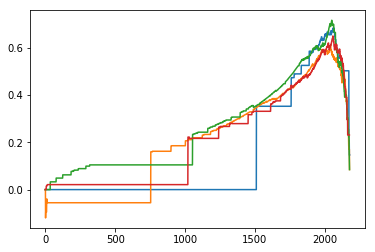

In [66]:
clf = []
val_mcc = []
val_pred = pd.DataFrame([])
proba = []
lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'None',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'binary', 
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }


for train_idx, val_idx in skf.split(train, target):
    X_tr, y_tr = train.iloc[train_idx, :], target[train_idx]
    X_val, y_val = train.iloc[val_idx, :], target[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30, feval=mcc_eval)
    pred_lgb = model_lgb.predict(X_val)
    
    best_proba, best_mcc, y_pred = eval_mcc(y_val, pred_lgb, show=True)
    val_mcc.append(best_mcc)
    proba.append(best_proba)
    
    pred_lgb = pd.DataFrame(pred_lgb, index=val_idx)
    val_pred = pd.concat([val_pred, pred_lgb], axis=1)
    
    clf.append(model_lgb)

In [67]:
proba

[0.14442127851038197,
 0.3866950352930241,
 0.30035363259977393,
 0.18003057972205594]

In [68]:
val_mcc

[0.6833494790423084, 0.6105423008758375, 0.7168059030781213, 0.649837774718752]

In [69]:
np.mean(val_mcc)

0.6651338644287548

In [70]:
from sklearn.metrics import confusion_matrix

confusion_matrix(target, (np.sum(val_pred, axis=1)>np.mean(proba)).astype(int))

array([[8019,  168],
       [ 213,  312]])

0.612003451962727 0.612003451962727


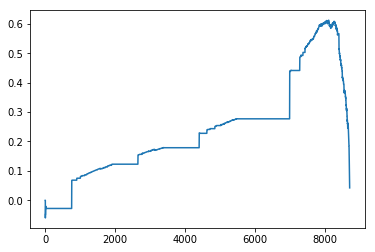

In [71]:
best_proba, best_mcc, y_pred = eval_mcc(target, np.sum(val_pred, axis=1), show=True)

In [72]:
feature_imp = np.zeros(train.shape[1])
for model in clf:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp/4, index=train.columns).sort_values(by=0, ascending=False)

,0
NumNegPeaks_ID,4320.179960
MeanAmpNeg_ID,1427.916961
MeanAmpPos_ID,613.567560
MinAmp_ID,591.458734
NumPeaks_ID,342.845996
NumPosPeaks_ID,323.190055
NegPeaksRatio,272.198699
MeanAmpAll_AD,248.790835
MaxAmp_ID,236.775129
MeanAmp_ID,154.569660


In [32]:
feature_imp = []
for model in clf:
    feature_imp.append(model.feature_importance(importance_type='gain'))

pd.DataFrame(feature_imp, columns=train.columns).T.sort_values(by=0, ascending=False)

,0,1,2,3
NumNegPeaks_ID,4000.909845,4074.474410,1891.963203,3690.936649
MeanAmpPos_ID,2001.040170,1971.730604,879.411797,1773.029776
NumPosPeaks_ID,1192.671361,877.112380,238.552895,962.838401
MeanAmpNeg_ID,531.885814,894.856174,550.580902,459.881309
MinAmp_ID,359.171139,937.695500,0.000000,102.719400
MeanAmp_ID,276.641772,256.135288,0.000000,180.273401
NumPeaks_ID,269.693029,1514.628725,105.570103,158.087301
MaxAmp_ID,232.247972,337.643080,0.000000,155.357900
id_measurement,149.521750,401.742897,0.000000,144.979603
phase,0.000000,0.000000,0.000000,0.000000


In [33]:
numpeaks = np.load('../features/numpeaks_test.npy')
numpospeaks = np.load('../features/numpospeaks_test.npy')
numnegpeaks = np.load('../features/numnegpeaks_test.npy')

maxpeakwidth = np.load('../features/maxpeakwidth_test.npy')
minpeakwidth = np.load('../features/minpeakwidth_test.npy')
meanpeakwidth = np.load('../features/meanpeakwidth_test.npy')
maxamp = np.load('../features/maxamp_test.npy')
minamp = np.load('../features/minamp_test.npy')
meanamp = np.load('../features/meanamp_test.npy')

stdampall = np.load('../features/stdampall_test.npy')
stdposall = np.load('../features/stdposall_test.npy')
stdwidthall = np.load('../features/stdwidthall_test.npy')

stdampq2 = np.load('../features/stdampq2_test.npy')
stdposq2 = np.load('../features/stdposq2_test.npy')
stdwidthq2 = np.load('../features/stdwidthq2_test.npy')
stdampq3 = np.load('../features/stdampq3_test.npy')
stdposq3 = np.load('../features/stdposq3_test.npy')
stdwidthq3 = np.load('../features/stdwidthq3_test.npy')
stdampq4 = np.load('../features/stdampq4_test.npy')
stdposq4 = np.load('../features/stdposq4_test.npy')
stdwidthq4 = np.load('../features/stdwidthq4_test.npy')


In [34]:
stdampall_ad = np.load('../features/stdampall_ad_test.npy')
stdampq2_ad = np.load('../features/stdampq2_ad_test.npy')
stdampq3_ad = np.load('../features/stdampq3_ad_test.npy')
stdampq4_ad = np.load('../features/stdampq4_ad_test.npy')

meanampall_ad = np.load('../features/meanampall_ad_test.npy')
meanampq2_ad = np.load('../features/meanampq2_ad_test.npy')
meanampq3_ad = np.load('../features/meanampq3_ad_test.npy')
meanampq4_ad = np.load('../features/meanampq4_ad_test.npy')

meanamppos = np.load('../features/meanamppos_test.npy')
meanampneg = np.load('../features/meanampneg_test.npy')


In [35]:
numpeaks_id = np.load('../features/numpeaks_id_test.npy')
numpospeaks_id = np.load('../features/numpospeaks_id_test.npy')
numnegpeaks_id = np.load('../features/numnegpeaks_id_test.npy')

maxamp_id = np.load('../features/maxamp_id_test.npy')
minamp_id = np.load('../features/minamp_id_test.npy')
meanamp_id = np.load('../features/meanamp_id_test.npy')

meanamppos_id = np.load('../features/meanamppos_id_test.npy')
meanampneg_id = np.load('../features/meanampneg_id_test.npy')


In [36]:
test_features = pd.DataFrame({'NumPeaks':numpeaks, 'NumPosPeaks':numpospeaks, 'NumNegPeaks':numnegpeaks, 'MaxWidth':maxpeakwidth,
                         'MinWidth':minpeakwidth, 'MeanWidth':meanpeakwidth, 'MaxAmp':maxamp, 'MinAmp':minamp, 'MeanAmp':meanamp,
                        'StdAmpAll':stdampall, 'StdPosAll':stdposall, 'StdWidthAll':stdwidthall, 'StdAmpQ2':stdampq2, 'StdPosQ2':stdposq2,
                         'StdWidthQ2':stdwidthq2, 'StdAmpQ3':stdampq3, 'StdPosQ3':stdposq3, 'StdWidthQ3':stdwidthq3,
                        'StdAmpQ4':stdampq4, 'StdPosQ4':stdposq4, 'StdWidthQ4':stdwidthq4, 
                        'StdAmpAll_AD':stdampall_ad, 'StdAmpQ2_AD': stdampq2_ad, 'StdAmpQ3_AD': stdampq3_ad, 'StdAmpQ4_AD': stdampq4_ad,
                        'MeanAmpAll_AD':meanampall_ad, 'MeanAmpQ2_AD': meanampq2_ad,
                        'MeanAmpQ3_AD': meanampq3_ad, 'MeanAmpQ4_AD': meanampq4_ad,
                        'MeanAmpPos':meanamppos, 'MeanAmpNeg':meanampneg,
                        'NumPeaks_ID':numpeaks_id[0:20000], 'NumPosPeaks_ID':numpospeaks_id[0:20000], 'NumNegPeaks_ID':numnegpeaks_id[0:20000],
                        'MaxAmp_ID':maxamp_id[0:20000], 'MinAmp_ID':minamp_id[0:20000], 'MeanAmp_ID':meanamp_id[0:20000],
                        'MeanAmpPos_ID':meanamppos_id[0:20000], 'MeanAmpNeg_ID':meanampneg_id[0:20000]})

In [37]:
test = pd.concat([meta_test, test_features], axis=1)

In [38]:
test_id = test['signal_id'].values
del test['signal_id']

In [39]:
preds = None
for model in clf:
    if preds is None:
        preds = model.predict(test)
    else:
        preds += model.predict(test)
    
preds = preds/4

In [40]:
submission = pd.DataFrame({'signal_id':test_id,'target':(preds>best_proba).astype(int)})

In [41]:
submission.to_csv('../output/submission_8.csv', index=False)